In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import re

from scipy.stats import hmean
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import norm

import string
import html
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

In [71]:
df = pd.read_csv('/Users/alenjose/Desktop/data/project_data/model_info/LSTM_BLM_prediction')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             41775 non-null  int64  
 1   date                   41775 non-null  object 
 2   year                   41775 non-null  int64  
 3   month                  41775 non-null  int64  
 4   tweet_text_with_sw     41775 non-null  object 
 5   tweet_text_without_sw  41743 non-null  object 
 6   user_name              41775 non-null  object 
 7   user_id                41775 non-null  float64
 8   user_follower_count    41775 non-null  int64  
 9   user_friend_count      41775 non-null  int64  
 10  user_statuses_count    41775 non-null  int64  
 11  tweet_reply_count      41775 non-null  int64  
 12  tweet_retweet_count    41775 non-null  int64  
 13  tweet_like_count       41775 non-null  int64  
 14  tweet_quote_count      41775 non-null  int64  
 15  tw

In [6]:
# first 5 rows
df.head()

Unnamed: 0                           date  year  month  \
0           1  2021-03-23 10:27:38.540305625  2021      3   
1           4  2022-05-24 08:51:10.357066577  2022      5   
2           6  2021-08-30 20:15:29.555728463  2021      8   
3           7  2022-12-12 13:11:13.285477333  2022     12   
4           9  2021-03-29 22:19:13.348853845  2021      3   

                                  tweet_text_with_sw  \
0  someone needs to check the keepers betway account   
1  consequences imagine that except at blm antifa...   
2  during the blm riots in the summer of and beyo...   
3  why didnt he say this to blm and the other act...   
4  guess yours has seen some shit its in his line...   

                               tweet_text_without_sw     user_name  \
0         someone needs check keepers betway account    ArsenalBLM   
1  consequences imagine that except blm antifa ri...   Apodroplane   
2  during blm riots summer beyond eric adams de b...    GabNYC2021   
3                        why didnt say blm activists       JCJ45LC   
4                      guess seen shit its line work  chiisaistars   

        user_id  user_follower_count  user_friend_count  user_statuses_count  \
0  1.293480e+18                  181                512                  229   
1  1.430000e+18                    9                204                  735   
2  3.658613e+07                  840               1340                11830   
3  5.653508e+08                  517               1450                 3002   
4  1.553117e+09                 2016               1078                64160   

   tweet_reply_count  tweet_retweet_count  tweet_like_count  \
0                  0                    0                 0   
1                  0                    0                 0   
2                  0                    0                 0   
3                  0                    0                 0   
4                  0                    0                 0   

   tweet_quote_count tweet_language  \
0                  0             en   
1                  0             en   
2                  0             en   
3                  0             en   
4                  0             en   

                               tweet_mentioned_users sentiments  
0                                                NaN   positive  
1  [User(username='ProudElephantUS', id=810055220...   positive  
2                                                NaN   positive  
3                                                NaN   negative  
4  [User(username='Baronduki', id=369819699, disp...   positive

In [7]:
# 0 - negative and 4 - positive
df['sentiments'].value_counts()

negative    20933
positive    20842
Name: sentiments, dtype: int64

# Data Visualization : 

## https://www.datacamp.com/tutorial/wordcloud-python

In [8]:
df.rename(columns={'sentiments':'target','tweet_text_without_sw':'tweet_text'},inplace=True)

In [9]:
df.target = df.target.replace({'negative':0,'positive':4})

In [13]:
df = df[df['tweet_text'].notnull()]

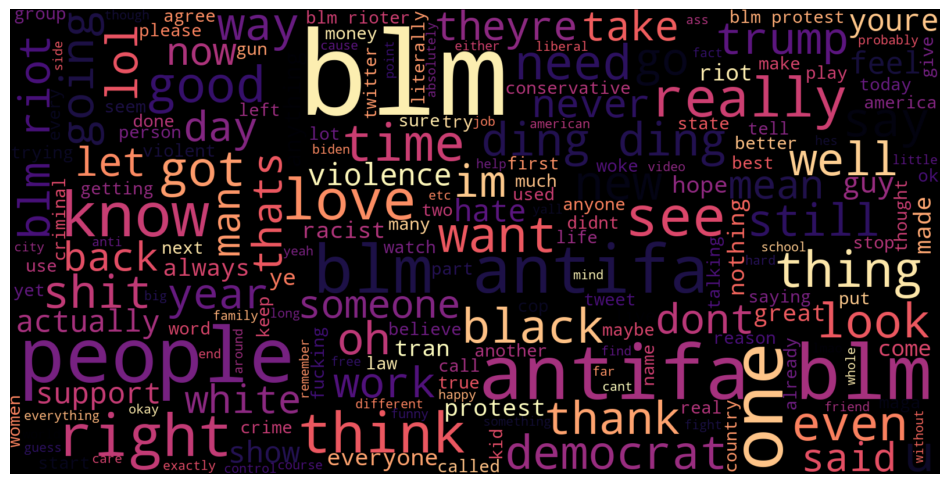

In [14]:
positive_text = []

def add_to_list(tweet):
    for word in tweet.split():
        positive_text.append(word)
        
df[df['target']==4].tweet_text.apply(lambda x:add_to_list(x))

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(' '.join(positive_text))

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

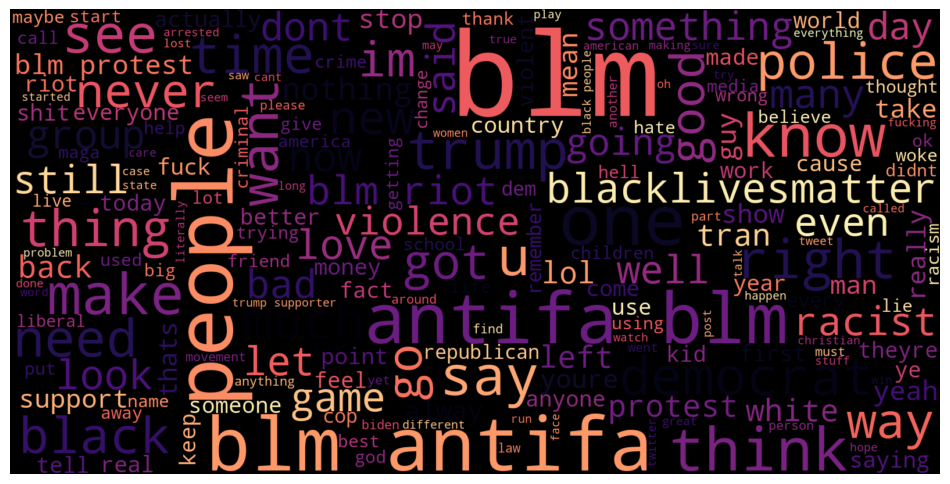

In [16]:
negative_text = []

def add_to_list(tweet):
    for word in tweet.split():
        negative_text.append(word)
        
df[df['target']==0].tweet_text.apply(lambda x:add_to_list(x))

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(' '.join(negative_text))

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

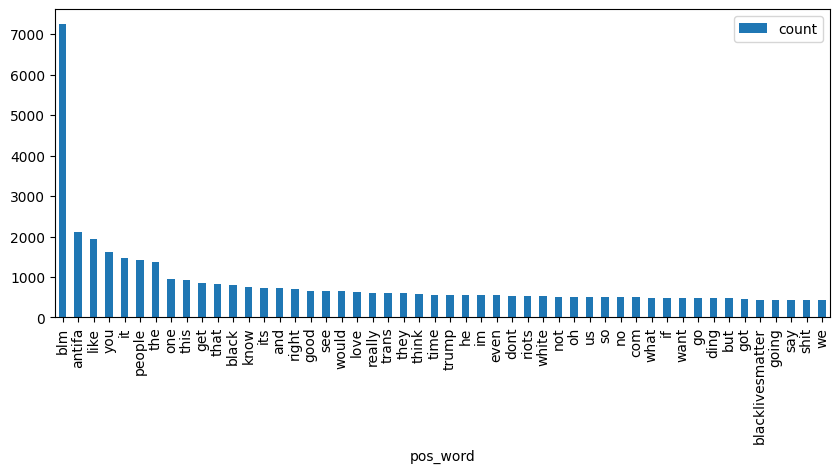

In [17]:
pos_count = {}
for word in positive_text:
    if word not in pos_count:
        pos_count[word] = 1
    elif word in pos_count:
        pos_count[word] += 1
# print(pos_count)

# https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
pos_term_df = pd.DataFrame(pos_count.items(),columns=['pos_word','count']).sort_values(by='count',ascending=False)
pos_term_df[:50].plot(x='pos_word',kind='bar',figsize=(10,4))
plt.show()

<AxesSubplot: xlabel='neg_word'>

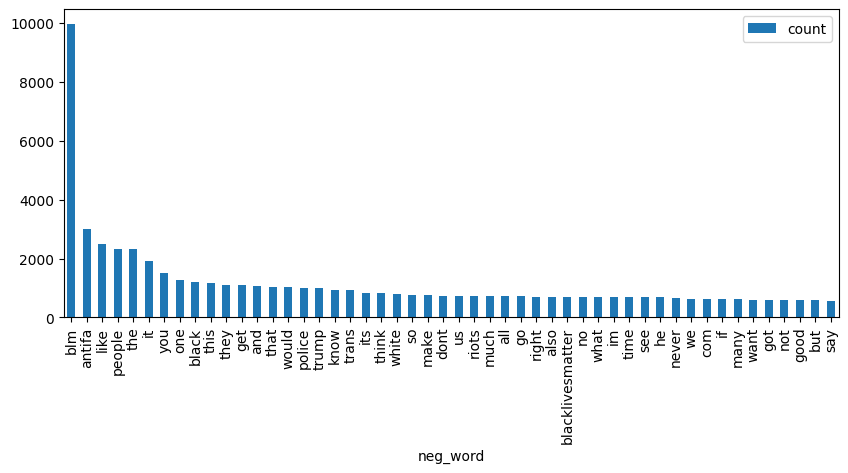

In [18]:
neg_count = {}
for word in negative_text:
    if word not in neg_count:
        neg_count[word] = 1
    elif word in neg_count:
        neg_count[word] += 1
# print(neg_count)

neg_term_df = pd.DataFrame(neg_count.items(),columns=['neg_word','count']).sort_values(by='count',ascending=False)
neg_term_df[:50].plot(x='neg_word',kind='bar',figsize=(10,4))

# Feature Extraction and summarization : 

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
cvec = CountVectorizer()
cvec.fit(df.tweet_text)

# cvec - count vectorizer
neg_matrix = cvec.transform(df[df.target == 0].tweet_text)
pos_matrix = cvec.transform(df[df.target == 4].tweet_text)

neg_df = np.sum(neg_matrix,axis=0)
pos_df = np.sum(pos_matrix,axis=0)

negative = np.squeeze(np.asarray(neg_df))
positive = np.squeeze(np.asarray(pos_df))

term_freq = pd.DataFrame([negative,positive],columns=cvec.get_feature_names_out()).transpose()

# token and its occurance in both classes (0-negative, 1-positive)
term_freq.head()

0  1
aa      3  3
aaa     1  1
aaaa    1  1
aaaaa   2  1
aaaaaa  0  1

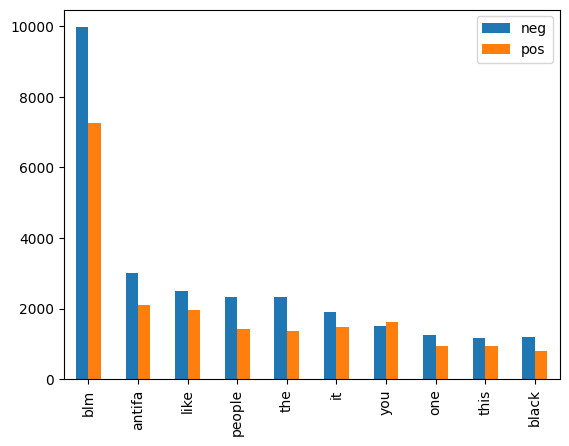

In [20]:
# renaming the columns
term_freq.columns = ['neg','pos']

# df with index as tokens and columns as occurance of token (in both target strings)
term_freq['total_count'] = term_freq['neg'] + term_freq['pos']

term_freq.sort_values(by='total_count', ascending=False).iloc[:10][['neg','pos']].plot(kind='bar')
plt.show()

<!--  -->

### It is clear from this plot that the most common words associated with both positive and negative tweets are words that contain no meaning (including stop words).  This could affect the model we intend to train.

# Removing stopwords and setting max_features to 10,000 

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(df.tweet_text)

CountVectorizer(max_features=10000, stop_words='english')

In [22]:
# cvec - count vectorizer
neg_matrix_1 = cvec.transform(df[df.target == 0].tweet_text)
pos_matrix_1 = cvec.transform(df[df.target == 4].tweet_text)

neg_df_1 = np.sum(neg_matrix_1,axis=0)
pos_df_1 = np.sum(pos_matrix_1,axis=0)

negative_1 = np.squeeze(np.asarray(neg_df_1))
positive_1 = np.squeeze(np.asarray(pos_df_1))

term_freq_1 = pd.DataFrame([negative_1,positive_1],columns=cvec.get_feature_names_out()).transpose()

# token and its occurance in both classes (0-negative, 1-positive)
term_freq_1.head()

0  1
aa       3  3
aaaaaaa  1  3
aab      2  2
ab       7  7
abandon  3  2

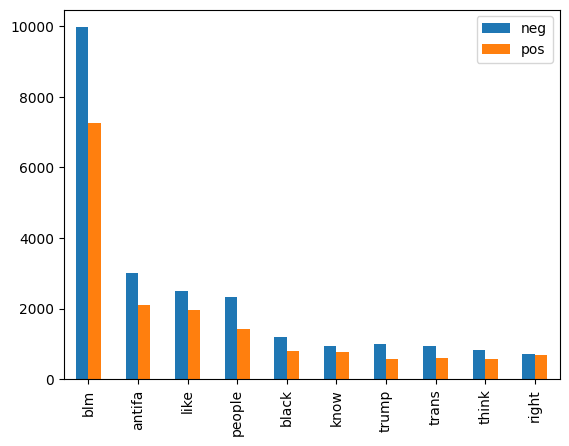

In [23]:
# renaming the columns
term_freq_1.columns = ['neg','pos']

# df with index as tokens and columns as occurance of token (in both target strings)
term_freq_1['total_count'] = term_freq_1['neg'] + term_freq_1['pos']

term_freq_1.sort_values(by='total_count', ascending=False).iloc[:10][['neg','pos']].plot(kind='bar')
plt.show()

## removing the stopwords made some improvements to the plot. It would also be better to remove the top 10-15 words found from the previous plot that wasnt included in the stopwords although there is a high probability that the stopwords from sklearn should contain all those words

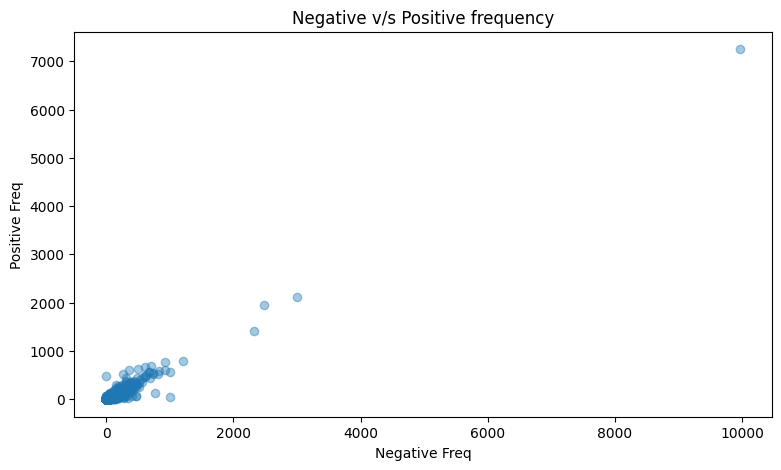

In [24]:
# https://seaborn.pydata.org/generated/seaborn.regplot.html
plt.figure(figsize=(9,5))
ax = sns.regplot(x="neg", y="pos",fit_reg=False, scatter_kws={'alpha':0.4},data=term_freq_1)
plt.ylabel('Positive Freq')
plt.xlabel('Negative Freq')
plt.title('Negative v/s Positive frequency')
plt.show()

## This plot isnt meaningful and there is no clear distinction between the positive and negative terms frequency. 
## We need to use some kind of metric that can detect important tokens from each class. 

## https://arxiv.org/pdf/1703.00565.pdf

### The intuition is that if a word if found more number of times in a class than the other class, then that word describes the fomer class better. 
### The equation would be :
###                    rate = class 1 freq / (class 1 freq + class 2 freq)

In [25]:
term_freq_1['total'] = term_freq_1['pos'] + term_freq_1['neg']

term_freq_1['pos_rate'] = term_freq_1['pos'] * 1./term_freq_1['total']
term_freq_1.sort_values(by='pos_rate', ascending=False).iloc[:10]

neg  pos  total_count  total  pos_rate
inauguration    0    5            5      5       1.0
splat           0    4            4      4       1.0
markle          0    6            6      6       1.0
rex             0    5            5      5       1.0
jeans           0    5            5      5       1.0
greenstein      0    6            6      6       1.0
bffr            0    4            4      4       1.0
splitting       0    4            4      4       1.0
tasty           0    5            5      5       1.0
empowering      0    6            6      6       1.0

In [26]:
# same for the negative class 
term_freq_1['neg_rate'] = term_freq_1['neg'] * 1./term_freq_1['total']

### Adding on to this: frequency of a word in its own class. 
### freq_pct = freq in class / class frequency 

In [27]:
term_freq_1['pos_freq_pct'] = term_freq_1['pos'] * 1./term_freq_1['pos'].sum()
term_freq_1['neg_freq_pct'] = term_freq_1['neg'] * 1./term_freq_1['neg'].sum()
term_freq_1.head()

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa         3    3            6      6      0.50      0.50      0.000019   
aaaaaaa    1    3            4      4      0.75      0.25      0.000019   
aab        2    2            4      4      0.50      0.50      0.000013   
ab         7    7           14     14      0.50      0.50      0.000044   
abandon    3    2            5      5      0.40      0.60      0.000013   

         neg_freq_pct  
aa           0.000014  
aaaaaaa      0.000005  
aab          0.000009  
ab           0.000032  
abandon      0.000014

### Issue with this is that first metric is more dominant and the second metric might lose its value.
### To resolve this I will try both/either of min-max normaliazation and z-score normalization.

In [28]:
# min-max :
term_freq_1['pos_rate_norm'] = (term_freq_1['pos_rate'] - term_freq_1['pos_rate'].min()) / (term_freq_1['pos_rate'].max() - term_freq_1['pos_rate'].min())
term_freq_1['pos_freq_norm'] = (term_freq_1['pos_freq_pct'] - term_freq_1['pos_freq_pct'].min()) / (term_freq_1['pos_freq_pct'].max() - term_freq_1['pos_freq_pct'].min())

term_freq_1['neg_rate_norm'] = (term_freq_1['neg_rate'] - term_freq_1['neg_rate'].min()) / (term_freq_1['neg_rate'].max() - term_freq_1['neg_rate'].min())
term_freq_1['neg_freq_norm'] = (term_freq_1['neg_freq_pct'] - term_freq_1['neg_freq_pct'].min()) / (term_freq_1['neg_freq_pct'].max() - term_freq_1['neg_freq_pct'].min())

In [23]:
# term_freq_1.drop(['pos_rate_norm' ,'pos_freq_pct' ,'neg_rate_norm' ,'neg_freq_pct'],axis=1,inplace=True)

### The difference between the two metrics were too big for min-max or z-score to work

### Moving on to harmonic mean, that combines both values to form 1 single metric.

In [29]:
term_freq_1

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa             3    3            6      6  0.500000  0.500000      0.000019   
aaaaaaa        1    3            4      4  0.750000  0.250000      0.000019   
aab            2    2            4      4  0.500000  0.500000      0.000013   
ab             7    7           14     14  0.500000  0.500000      0.000044   
abandon        3    2            5      5  0.400000  0.600000      0.000013   
...          ...  ...          ...    ...       ...       ...           ...   
zoom           2    5            7      7  0.714286  0.285714      0.000032   
ztrc          15    0           15     15  0.000000  1.000000      0.000000   
zuckerberg     3    6            9      9  0.666667  0.333333      0.000038   
zuckerbucks    2   10           12     12  0.833333  0.166667      0.000063   
zzel           6    3            9      9  0.333333  0.666667      0.000019   

             neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
aa               0.000014       0.500000       0.000414       0.500000   
aaaaaaa          0.000005       0.750000       0.000414       0.250000   
aab              0.000009       0.500000       0.000276       0.500000   
ab               0.000032       0.500000       0.000966       0.500000   
abandon          0.000014       0.400000       0.000276       0.600000   
...                   ...            ...            ...            ...   
zoom             0.000009       0.714286       0.000690       0.285714   
ztrc             0.000068       0.000000       0.000000       1.000000   
zuckerberg       0.000014       0.666667       0.000828       0.333333   
zuckerbucks      0.000009       0.833333       0.001380       0.166667   
zzel             0.000027       0.333333       0.000414       0.666667   

             neg_freq_norm  
aa                0.000301  
aaaaaaa           0.000100  
aab               0.000201  
ab                0.000702  
abandon           0.000301  
...                    ...  
zoom              0.000201  
ztrc              0.001505  
zuckerberg        0.000301  
zuckerbucks       0.000201  
zzel              0.000602  

[10000 rows x 12 columns]

In [30]:
# add small constant to avoid division by zero
constant = 1e-10

# harmonic mean
term_freq_1['pos_harmonic_mean'] = hmean(term_freq_1[['pos_rate', 'pos_freq_pct']].replace(0, constant), axis=1)
term_freq_1['neg_harmonic_mean'] = hmean(term_freq_1[['neg_rate', 'neg_freq_pct']].replace(0, constant), axis=1)
term_freq_1.sort_values(by='pos_harmonic_mean',ascending=False).iloc[:10]

neg   pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
blm     9970  7249        17219  17219  0.420988  0.579012      0.045971   
antifa  3000  2107         5107   5107  0.412571  0.587429      0.013362   
like    2483  1946         4429   4429  0.439377  0.560623      0.012341   
people  2324  1415         3739   3739  0.378443  0.621557      0.008973   
black   1207   797         2004   2004  0.397705  0.602295      0.005054   
know     927   761         1688   1688  0.450829  0.549171      0.004826   
right    709   691         1400   1400  0.493571  0.506429      0.004382   
good     606   664         1270   1270  0.522835  0.477165      0.004211   
love     504   635         1139   1139  0.557507  0.442493      0.004027   
really   358   612          970    970  0.630928  0.369072      0.003881   

        neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
blm         0.044957       0.420988       1.000000       0.579012   
antifa      0.013528       0.412571       0.290661       0.587429   
like        0.011196       0.439377       0.268451       0.560623   
people      0.010479       0.378443       0.195199       0.621557   
black       0.005443       0.397705       0.109946       0.602295   
know        0.004180       0.450829       0.104980       0.549171   
right       0.003197       0.493571       0.095323       0.506429   
good        0.002733       0.522835       0.091599       0.477165   
love        0.002273       0.557507       0.087598       0.442493   
really      0.001614       0.630928       0.084425       0.369072   

        neg_freq_norm  pos_harmonic_mean  neg_harmonic_mean  
blm          1.000000           0.082890           0.083436  
antifa       0.300903           0.025885           0.026446  
like         0.249047           0.024008           0.021954  
people       0.233099           0.017531           0.020611  
black        0.121063           0.009982           0.010788  
know         0.092979           0.009550           0.008297  
right        0.071113           0.008687           0.006354  
good         0.060782           0.008354           0.005434  
love         0.050552           0.007996           0.004522  
really       0.035908           0.007715           0.003215

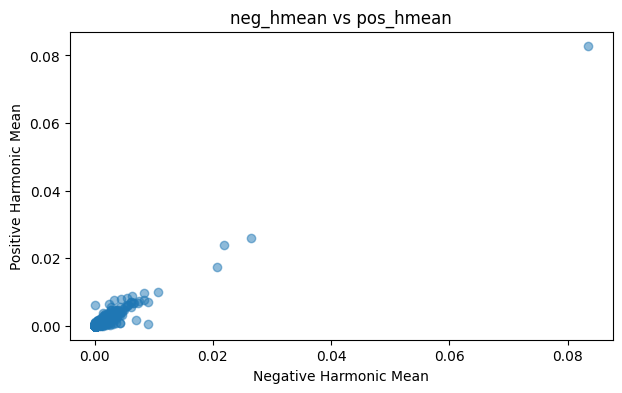

In [31]:
plt.figure(figsize=(7,4))
ax = sns.regplot(x="neg_harmonic_mean", 
                 y="pos_harmonic_mean",
                 fit_reg=False, 
                 scatter_kws={'alpha':0.5},
                 data=term_freq_1)
plt.ylabel('Positive Harmonic Mean')
plt.xlabel('Negative Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')
plt.show()

## I am still not able to find a seperation between the 2 classes. 
## Lets perform CDF : 

In [32]:
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_1['pos_rate_normcdf'] = normcdf(term_freq_1['pos_rate'])
term_freq_1['pos_freq_pct_normcdf'] = normcdf(term_freq_1['pos_freq_pct'])
term_freq_1['pos_normcdf_hmean'] = hmean([term_freq_1['pos_rate_normcdf'], term_freq_1['pos_freq_pct_normcdf']])

term_freq_1.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
ding       0  481          481    481  1.000000  0.000000      0.003050   
thank    148  301          449    449  0.670379  0.329621      0.001909   
oh       264  513          777    777  0.660232  0.339768      0.003253   
really   358  612          970    970  0.630928  0.369072      0.003881   
okay      58  128          186    186  0.688172  0.311828      0.000812   
morning   52  116          168    168  0.690476  0.309524      0.000736   
mind      62  124          186    186  0.666667  0.333333      0.000786   
great    192  278          470    470  0.591489  0.408511      0.001763   
anti     154  225          379    379  0.593668  0.406332      0.001427   
shit     307  435          742    742  0.586253  0.413747      0.002759   

         neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
ding         0.000000       1.000000       0.066354       0.000000   
thank        0.000667       0.670379       0.041523       0.329621   
oh           0.001190       0.660232       0.070768       0.339768   
really       0.001614       0.630928       0.084425       0.369072   
okay         0.000262       0.688172       0.017658       0.311828   
morning      0.000234       0.690476       0.016002       0.309524   
mind         0.000280       0.666667       0.017106       0.333333   
great        0.000866       0.591489       0.038350       0.408511   
anti         0.000694       0.593668       0.031039       0.406332   
shit         0.001384       0.586253       0.060008       0.413747   

         neg_freq_norm  pos_harmonic_mean  neg_harmonic_mean  \
ding          0.000000           0.006082       1.000000e-10   
thank         0.014845           0.003807       1.332031e-03   
oh            0.026479           0.006475       2.372554e-03   
really        0.035908           0.007715       3.214539e-03   
okay          0.005817           0.001622       5.226308e-04   
morning       0.005216           0.001470       4.686036e-04   
mind          0.006219           0.001571       5.586743e-04   
great         0.019258           0.003515       1.727877e-03   
anti          0.015446           0.002847       1.386469e-03   
shit          0.030792           0.005491       2.759427e-03   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
ding             0.997869              1.000000           0.998933  
thank            0.888124              0.999383           0.940475  
oh               0.878210              1.000000           0.935156  
really           0.846173              1.000000           0.916678  
okay             0.904091              0.898187           0.901129  
morning          0.906030              0.871887           0.888631  
mind             0.884567              0.889896           0.887224  
great            0.794963              0.998513           0.885187  
anti             0.798031              0.991107           0.884151  
shit             0.787474              0.999999           0.881102

In [33]:
term_freq_1.head(1)

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa    3    3            6      6       0.5       0.5      0.000019   

    neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  neg_freq_norm  \
aa      0.000014            0.5       0.000414            0.5       0.000301   

    pos_harmonic_mean  neg_harmonic_mean  pos_rate_normcdf  \
aa           0.000038           0.000027          0.643625   

    pos_freq_pct_normcdf  pos_normcdf_hmean  
aa              0.442499            0.52444

In [34]:
# cumulative distribution function
def cumulative_distribution_function(value):
    return norm.cdf(value, value.mean(), value.std())

# cdf for 'pos_rate' and 'pos_freq_pct'
term_freq_1['norm_pos_rate_cdf'] = cumulative_distribution_function(term_freq_1['pos_rate'])
term_freq_1['norm_pos_frequency_cdf'] = cumulative_distribution_function(term_freq_1['pos_freq_pct'])

# cdf for 'neg_rate' and 'neg_freq_pct'
term_freq_1['norm_neg_rate_cdf'] = cumulative_distribution_function(term_freq_1['neg_rate'])
term_freq_1['norm_neg_frequency_cdf'] = cumulative_distribution_function(term_freq_1['neg_freq_pct'])

# harmonic mean of the two new columns:
term_freq_1['pos_harmonic_mean_norm_cdf'] = hmean([term_freq_1['norm_pos_rate_cdf'], term_freq_1['norm_pos_frequency_cdf']])
term_freq_1['neg_harmonic_mean_norm_cdf'] = hmean([term_freq_1['norm_neg_rate_cdf'], term_freq_1['norm_neg_frequency_cdf']])

# sort by harmonic mean column 
term_freq_1.sort_values(by='pos_harmonic_mean_norm_cdf', ascending=False).iloc[:10]

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
ding       0  481          481    481  1.000000  0.000000      0.003050   
thank    148  301          449    449  0.670379  0.329621      0.001909   
oh       264  513          777    777  0.660232  0.339768      0.003253   
really   358  612          970    970  0.630928  0.369072      0.003881   
okay      58  128          186    186  0.688172  0.311828      0.000812   
morning   52  116          168    168  0.690476  0.309524      0.000736   
mind      62  124          186    186  0.666667  0.333333      0.000786   
great    192  278          470    470  0.591489  0.408511      0.001763   
anti     154  225          379    379  0.593668  0.406332      0.001427   
shit     307  435          742    742  0.586253  0.413747      0.002759   

         neg_freq_pct  pos_rate_norm  pos_freq_norm  ...  neg_harmonic_mean  \
ding         0.000000       1.000000       0.066354  ...       1.000000e-10   
thank        0.000667       0.670379       0.041523  ...       1.332031e-03   
oh           0.001190       0.660232       0.070768  ...       2.372554e-03   
really       0.001614       0.630928       0.084425  ...       3.214539e-03   
okay         0.000262       0.688172       0.017658  ...       5.226308e-04   
morning      0.000234       0.690476       0.016002  ...       4.686036e-04   
mind         0.000280       0.666667       0.017106  ...       5.586743e-04   
great        0.000866       0.591489       0.038350  ...       1.727877e-03   
anti         0.000694       0.593668       0.031039  ...       1.386469e-03   
shit         0.001384       0.586253       0.060008  ...       2.759427e-03   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  \
ding             0.997869              1.000000           0.998933   
thank            0.888124              0.999383           0.940475   
oh               0.878210              1.000000           0.935156   
really           0.846173              1.000000           0.916678   
okay             0.904091              0.898187           0.901129   
morning          0.906030              0.871887           0.888631   
mind             0.884567              0.889896           0.887224   
great            0.794963              0.998513           0.885187   
anti             0.798031              0.991107           0.884151   
shit             0.787474              0.999999           0.881102   

         norm_pos_rate_cdf  norm_pos_frequency_cdf  norm_neg_rate_cdf  \
ding              0.997869                1.000000           0.002131   
thank             0.888124                0.999383           0.111876   
oh                0.878210                1.000000           0.121790   
really            0.846173                1.000000           0.153827   
okay              0.904091                0.898187           0.095909   
morning           0.906030                0.871887           0.093970   
mind              0.884567                0.889896           0.115433   
great             0.794963                0.998513           0.205037   
anti              0.798031                0.991107           0.201969   
shit              0.787474                0.999999           0.212526   

         norm_neg_frequency_cdf  pos_harmonic_mean_norm_cdf  \
ding                   0.427878                    0.998933   
thank                  0.848813                    0.940475   
oh                     0.976271                    0.935156   
really                 0.997045                    0.916678   
okay                   0.615483                    0.901129   
morning                0.596561                    0.888631   
mind                   0.627949                    0.887224   
great                  0.918041                    0.885187   
anti                   0.860048                    0.884151   
shit                   0.990219                    0.881102   

         neg_harmonic_mean_norm_cdf  
ding  

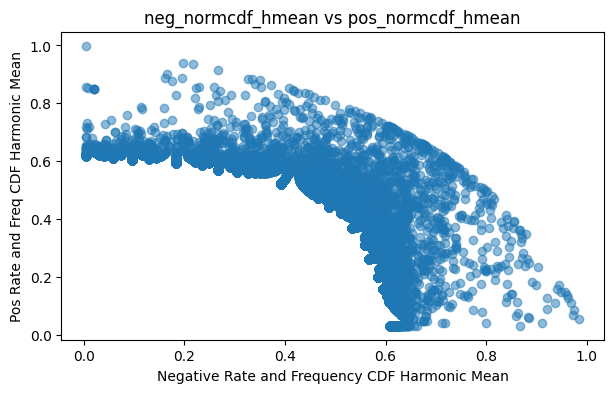

In [35]:
plt.figure(figsize=(7,4))
ax = sns.regplot(x="neg_harmonic_mean_norm_cdf", y="pos_harmonic_mean_norm_cdf",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_1)
plt.ylabel('Pos Rate and Freq CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

plt.show()

In [36]:
fig = px.scatter(term_freq_1, 
                 x="neg_harmonic_mean_norm_cdf", 
                 y="pos_harmonic_mean_norm_cdf", 
                 hover_data=[term_freq_1.index])

fig.update_layout(
    title='Neg NormCDF Harmonic Mean vs Pos NormCDF Harmonic Mean',
    xaxis=dict(title='Negative Rate and Frequency CDF Harmonic Mean'),
    yaxis=dict(title='Pos Rate and Freq CDF Harmonic Mean'),
    hovermode="closest")

fig.show()

In [67]:
# # positive tweets
# df_positive = df[df['target'] == 4]

# # group by year and month, then count positive tweets
# grouped = df_positive.groupby(['year', 'month']).size().reset_index(name='Positive_Count')

# # 'year-month'
# grouped['year_month'] = grouped['year'].astype(str) + '-' + grouped['month'].astype(str).str.zfill(2)

# # average positive tweets
# grouped['Positive_Avg'] = grouped['Positive_Count'] / grouped['Positive_Count'].sum()

# plt.figure(figsize=(12, 6))
# plt.bar(grouped['year_month'], grouped['Positive_Avg'], color='blue')
# plt.xlabel('Year-Month')
# plt.ylabel('Average Positive Tweets')
# plt.title('Average Number of Positive Tweets by Month')
# plt.xticks(rotation=45)
# plt.show()

In [68]:
# total = df.year.value_counts().reset_index().rename(columns={'index':'year','year':'total_count'})
# df_merged = pd.merge(grouped_year, total, on='year', how='inner')
# df_merged['ratio'] = df_merged['Positive_Count'] / df_merged['total_count']

# plt.figure(figsize=(8, 5))
# plt.bar(df_merged['year'].astype(str), df_merged['ratio'], color='green')
# plt.xlabel('Year')
# plt.ylabel('Average Positive Tweets')
# plt.title('Average Number of Positive Tweets by Year')
# plt.xticks(rotation=45)
# plt.show()

In [69]:
# # Convert target to 1 for positive sentiment and 0 for negative sentiment
# df['binary_target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# # Calculate correlation
# correlation = df[['user_follower_count', 'binary_target']].corr(method='pearson')
# print(f"Pearson correlation between user follower count and sentiment: {correlation.loc['user_follower_count', 'binary_target']}")